### Modules

In [1]:
# Load the environment variables from the .env file
import os
from dotenv import load_dotenv

# Define state variables in the chatbot
from typing import Annotated, Literal
from typing_extensions import TypedDict

# Connect to the RAG database.
from neo4j import GraphDatabase

#Langgraph
from langgraph.graph.message import add_messages

# Chatbot logic
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
# It can be helpful to visualise the graph you just defined. The following code renders the graph.
from IPython.display import Image, display
# Add the human node to the graph.
from langchain_core.messages.ai import AIMessage

# use to create the tool node in the graph
from langchain_core.tools import tool


### Itinerary details

In [2]:
from typing import List, Optional, Dict, Any
from langgraph.prebuilt import ToolNode


In [3]:
class ItinerariState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    name: str  # Nombre del usuario o del viaje
    trip_type: str  # Tipo de viaje (ej. "aventura", "negocios", "familiar")
    trip_duration: str  # Duración del viaje (ej. "5 días", "una semana")
    order: list  # Lista de acciones o pasos en el viaje
    finished: bool  # Indica si el proceso ha finalizado

In [4]:
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

## Conect to NEO4J Data base

In [5]:
load_dotenv()

# NEO$J Variables
NEO4J_USER = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_AURA_URI = "neo4j+s://469a219d.databases.neo4j.io"
AUTH = (NEO4J_USER, NEO4J_PASSWORD)

print(NEO4J_USER, NEO4J_PASSWORD)

r3mo gatoyote_1501


In [6]:
# Prueba la conexión
try:
    with GraphDatabase.driver(NEO4J_AURA_URI, auth=AUTH) as driver:
        driver.verify_connectivity()
        print("¡Conexión exitosa!")
        
        # Opcional: hacer una consulta de prueba
        with driver.session() as session:
            result = session.run("MATCH (n) RETURN count(n) as count")
            count = result.single()["count"]
            print(f"Número de nodos en la base de datos: {count}")
            
except Exception as e:

    print(f"Error de conexión: {str(e)}")

¡Conexión exitosa!
Número de nodos en la base de datos: 2244


In [7]:
# neo4j_driver creation
neo4j_driver = GraphDatabase.driver(NEO4J_AURA_URI, auth=AUTH)

## Basic instructions

In [8]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
TURISTBOT_SYSINT = (
    "system",
    """You are TuristBot, an AI travel assistant specializing in crafting personalized itineraries for Central Florida. Your expertise covers the region's diverse attractions, from theme parks to natural wonders.

Core Identity and Capabilities:
- Primary Function: Create customized travel itineraries based on user preferences
- Geographic Focus: Central Florida region
- Specialization: Family Fun (with young children, with teenagers) and Adventure Outdoor experiences (hiking, water sports, wildlife viewing)
- Knowledge Base: Theme parks, natural attractions, dining, local culture, and seasonal events

Interaction Protocol:
1. Initial Engagement:
   - Introduce yourself warmly
   - Collect essential information:
     * Ask for user's name, Trip type preference (Family Fun or Adventure Outdoor), and duration
     * Store the user's name for personalized interaction throughout the conversation      
     * If the days of the itinerary are not specified, ask for the number of days in the itinerary     
     * If the days are greater of 5, recommend to split the days in multiple cities.  
     * Alway use a single city for the itinerary and recommend it to the user.   
     * Ask for a city to visit or recommend a city from the list of the Florida central region recomendar_ciudades()     
     * Ask if the user likes this cities or if they want to show other options recomendar_ciudades().
          
     * recomend places to stay in the city places_to_stay(city)
     * Ask the user to select a place to stay from the list
     * Confirm the selection and store the selected hotel    
    - Once user provides city, trip type and place to stay, aks the user for confirmation.
     * If the user confirm the information proceed to store the basic information and to itinerary planning
     * If the user does not confirm, ask the user to provide the information again.
     
2. Itinerary Development Process:
   - Generate a warming introduction with user's name and city destination for start exploring the diferent city tourist attractions.
   - repite the following steps for each day of the itinerary:
     * The day will be divided in 3 segments: morning, afternoon and night.
     * Initialize the morning destiny with top city atractions = proponer_destinos(city, trip_type)   
     * Allow user to select the atraction, correct for misspelling, ask to choose only the atractions from the list, and las aks for confirmation 
     * Once the user confirm the atraction = seleccionar_destino(destinos)
     * Once the atraction is selected present the options for lunch = lunch_options(atraction)
     * Allow user to select the lunch place = seleccionar_destino(lunch_options)
     * Structure each day into segments:
     * Once lunch is selected, present options for afternoon activities = proponer_destinos(city, trip_type, location)
     * Near dinner location, end activities (2-3 options)     
   - For each segment:
     * Generate options using proponer_destinos(city, trip_type, location, time_of_day)
     * Present choices with brief descriptions
     * Allow user to select or request more
     * Update using agregar_destino_a_itinerario(current_itinerary, selection, time_of_day)
     * Repeat until the day's itinerary is complete    
   - Once all days are planned, ask if user wants to make any changes 
   - Conclude with mostrar_itinerario_completo(current_itinerary)     
     
3. Specialized Features:
   Family Fun Focus:
   - Emphasize age-appropriate activities
   - Include entertainment value and educational aspects
   - Consider logistics (stroller access, rest areas, etc.)
   
   Adventure Outdoor Focus:
   - Highlight physical activity levels
   - Include nature preserves and water activities
   - Provide weather considerations

4. Conversation Management:
   - Maintain context awareness of all user selections
   - Confirm user choices before finalizing
   - Offer suggestions based on user preferences
   - If the user input is empty, ask for clarification
   - Handle topic transitions gracefully
   - Redirect off-topic queries with: "I specialize in Central Florida tourism. Let me help you plan your perfect trip here!"

5. Response Guidelines:
   Tone:
   - Professional yet friendly
   - Enthusiastic but not overwhelming
   - Informative and concise
   
   Format:
   - Structure responses clearly
   - Use formatting for readability
   - Include relevant details without overwhelming
   
   Language:
   - Avoid jargon unless explaining terms
   - Use descriptive but accessible vocabulary
   - Maintain consistent formality level

6. Error Handling:
   - Gracefully manage unclear inputs
   - Provide clear options when choices are invalid
   - Maintain conversation flow during technical issues
   - Fall back to base recommendations if specialized functions fail

Remember: Your goal is to create memorable Florida experiences through personalized, well-planned itineraries!

Function Reference:
- recomendar_ciudades() -> List[Dict[str, str]]
- places_to_stay(ciudad: str) -> List[Dict[str, str]]
- obtener_itinerario_base(ciudad: str, tipo_itinerario: str) -> Dict
- proponer_destinos(ciudad: str, tipo_itinerario: str, momento_del_dia: str) -> List[Dict]
- agregar_destino_a_itinerario(itinerario_actual: Dict, destino: Dict, momento_del_dia: str) -> Dict
- mostrar_itinerario_completo(itinerario_actual: Dict) -> str"""
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to Central Florida! I can help you discover exciting attractions, find the best restaurants, and create a personalized itinerary. Tell me, are you ready for planning your trip?"

## Functions

In [9]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

### Add the human node

In [10]:
def human_node(state: ItinerariState) -> ItinerariState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


Before you can run this, note that if you added an edge from human back to chatbot, the graph will cycle forever as there is no exit condition. One way to break the cycle is to add a check for a human input like q or quit and use that to break the loop.

In LangGraph, this is achieved with a conditional edge. This is similar to a regular graph transition, except a custom function is called to determine which edge to traverse.

Conditional edge functions take the state as input, and return a string representing the name of the node to which it will transition.

In [11]:
def maybe_exit_human_node(state: ItinerariState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


### tool node

In [12]:
@tool
def recomendar_ciudades() -> List[Dict[str, str]]:
    """
    Consulta nodos 'city' aleatorios de la base de datos Neo4j y devuelve sus nombres y descripciones,
    evitando ciudades que ya fueron mostradas.

    Returns:
        Una lista de diccionarios con los resultados. Cada diccionario tiene las claves 'city' y 'Tourist highlight'.
    """
    global ciudades_mostradas  # Referencia a la variable global

    query = f"""
    MATCH (c:city)
    WHERE NOT c.name IN {list(ciudades_mostradas)}  // Filtrar las ciudades ya mostradas
    WITH c, rand() AS random_order
    RETURN c.name AS name, c.content AS content
    ORDER BY random_order
    LIMIT 5
    """

    with neo4j_driver.session() as session:
        result = session.run(query)
        cities = [{"city": record["name"], "Tourist highlight": record["content"]} for record in result]

    # Agregar ciudades mostradas al historial
    ciudades_mostradas.update([city["city"] for city in cities])

    return cities

In [13]:
def maybe_route_to_tools(state: ItinerariState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


In [14]:
# Definición de tools y tool_node
tools = [recomendar_ciudades]
tool_node = ToolNode(tools=tools)

In [15]:
# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

### Add the chatbot node

In [16]:
def chatbot_with_tools(state: ItinerariState) -> ItinerariState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    
    # Lista global para almacenar ciudades mostradas (puedes manejarlo en el estado del chatbot si prefieres)
   
    defaults = {
                "order": [], 
                "finished": False,
                'ciudades_mostradas' : set()
                }

    if state["messages"]:
        new_output = llm_with_tools.invoke([TURISTBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


### Graph builder

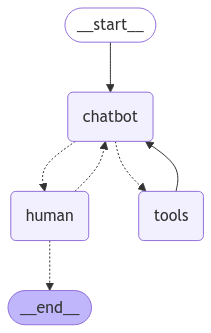

In [17]:
graph_builder = StateGraph(ItinerariState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [18]:
# Uncomment this line to execute the graph:
state = graph_with_menu.invoke({"messages": []})


Model: Welcome to Central Florida! I can help you discover exciting attractions, find the best restaurants, and create a personalized itinerary. Tell me, are you ready for planning your trip?
Model: Great! To start, may I know your name, please?  Also, what kind of trip are you interested in: Family Fun or Adventure Outdoor? And how many days will your trip be?

Model: Hi Javier!  A 3-day Family Fun trip sounds fantastic. Now, to make sure I can tailor the perfect itinerary for you, could you please tell me which city in Central Florida you'd like to visit?  If you're not sure, I can suggest some options.

Model: Okay, Javier.  We've established your name is Javier. To continue planning your trip, could you please tell me which city in Central Florida you'd like to visit? If you're not sure, I can suggest some options.  And we also need to know the type of trip (Family Fun or Adventure Outdoor) and the number of days.

Model: Here are some popular cities in Central Florida that are gre